In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
# this is the mean and std of MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

# input[channel] = ((input[channel] - mean[channel]) / std[channel])
transformations = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean_gray, ), (stddev_gray, ))])

train_dataset = datasets.MNIST(root="./data",
                               train=True,
                               transform=transformations,
                               download=True)

test_dataset = datasets.MNIST(root="./data",
                               train=False,
                               transform=transformations)

100%|██████████| 9912422/9912422 [00:00<00:00, 504976330.52it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25784524.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 163496250.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19844300.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



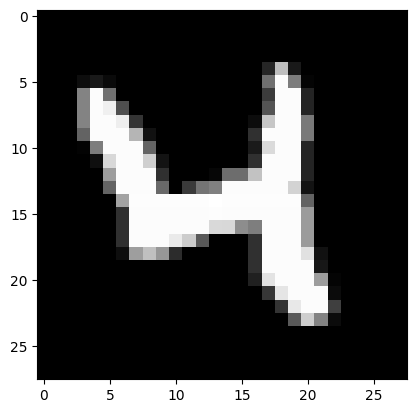

In [ ]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28, 28), cmap='gray')

In [ ]:
train_dataset[20][1]

4

In [ ]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_load = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:
len(train_load), len(test_load), len(train_dataset), len(test_dataset)

(600, 100, 60000, 10000)

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    # valid wont apply padding same will add padding to retain input size
    # padding = (filtersize - 1) / 2
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    # the output size of each of 8 feature map :
    # [(input_size - filter_size + 2(padding)) / stride + 1] = (28 -3 + 2(1))/1 + 1 = 28
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    # the output size = 28/2 = 14
    # same padding = (filtersize-1)/2 = (5-1)/2 = 2
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    # output size of each of the 32 feature maps [(14-5 + 2(2)/1 + 1)] = 14
    self.batchnorm2 = nn.BatchNorm2d(32)
    # flattern the 32 feature maps = 7*7*32 = 1568
    self.fc1 = nn.Linear(1568, 600)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(600, 10)

  def forward(self, x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)

    out = out.view(batch_size, 1568) # (-1, 1568) flattening

    # Fc
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)

    return out

In [ ]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
CUDA

True

In [ ]:
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_load):
  if CUDA:
    inputs = inputs.cuda()
    labels = labels.cuda()

  print("For one iteration: ")
  print('Input shape: ', inputs.shape)
  print('Labels shape: ', labels.shape)

  output = model(inputs)

  _, predicted = torch.max(output, 1)

  print('Predicted shape', predicted.shape)
  print('Predicted Tensor: ')
  print(predicted)

  correct += (predicted == labels).sum()
  break




For one iteration: 
Input shape:  torch.Size([100, 1, 28, 28])
Labels shape:  torch.Size([100])
Predicted shape torch.Size([100])
Predicted Tensor: 
tensor([8, 8, 6, 3, 8, 6, 0, 8, 0, 4, 6, 6, 0, 0, 1, 3, 5, 8, 8, 9, 0, 8, 0, 0,
        1, 8, 5, 3, 8, 8, 3, 1, 6, 1, 8, 5, 7, 0, 0, 8, 6, 0, 6, 0, 5, 6, 5, 0,
        0, 0, 3, 0, 0, 6, 8, 3, 0, 0, 6, 8, 8, 0, 8, 7, 8, 0, 0, 8, 0, 8, 0, 0,
        1, 6, 8, 0, 5, 0, 6, 5, 8, 8, 6, 0, 0, 6, 6, 6, 1, 0, 5, 0, 0, 0, 2, 0,
        8, 1, 4, 9], device='cuda:0')


In [ ]:
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
  # training phase
  correct = 0
  iterations = 0
  iter_loss = 0
  model.train()
  for i, (inputs,labels) in enumerate(train_load):
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs) # model.forward(inputs)
    loss = loss_fn(outputs, labels)
    iter_loss += loss.item()

    optimizer.zero_grad() # w <-- w - lr * gradients
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    iterations += 1

  train_loss.append(iter_loss / iterations)
  train_accuracy.append((100 * correct / len(train_dataset)))

  # Testing phase
  testing_loss = 0.0
  correct = 0
  iterations = 0

  model.eval()

  for i, (inputs,labels) in enumerate(test_load):
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs) # model.forward(inputs)
    loss = loss_fn(outputs, labels)
    testing_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    iterations += 1

  test_loss.append(testing_loss / iterations)
  test_accuracy.append((100 * correct / len(test_dataset)))

  print("Epoch {} / {} , Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(
      epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))






Epoch 1 / 10 , Training Loss: 0.129, Training Accuracy: 96.230, Testing Loss: 0.038, Testing Accuracy: 98.830
Epoch 2 / 10 , Training Loss: 0.095, Training Accuracy: 97.258, Testing Loss: 0.035, Testing Accuracy: 98.960
Epoch 3 / 10 , Training Loss: 0.079, Training Accuracy: 97.823, Testing Loss: 0.036, Testing Accuracy: 98.920
Epoch 4 / 10 , Training Loss: 0.071, Training Accuracy: 97.985, Testing Loss: 0.048, Testing Accuracy: 98.520
Epoch 5 / 10 , Training Loss: 0.065, Training Accuracy: 98.105, Testing Loss: 0.041, Testing Accuracy: 98.720
Epoch 6 / 10 , Training Loss: 0.061, Training Accuracy: 98.315, Testing Loss: 0.033, Testing Accuracy: 98.970
Epoch 7 / 10 , Training Loss: 0.054, Training Accuracy: 98.413, Testing Loss: 0.030, Testing Accuracy: 99.100
Epoch 8 / 10 , Training Loss: 0.053, Training Accuracy: 98.452, Testing Loss: 0.037, Testing Accuracy: 99.000
Epoch 9 / 10 , Training Loss: 0.048, Training Accuracy: 98.648, Testing Loss: 0.034, Testing Accuracy: 99.050
Epoch 10 /

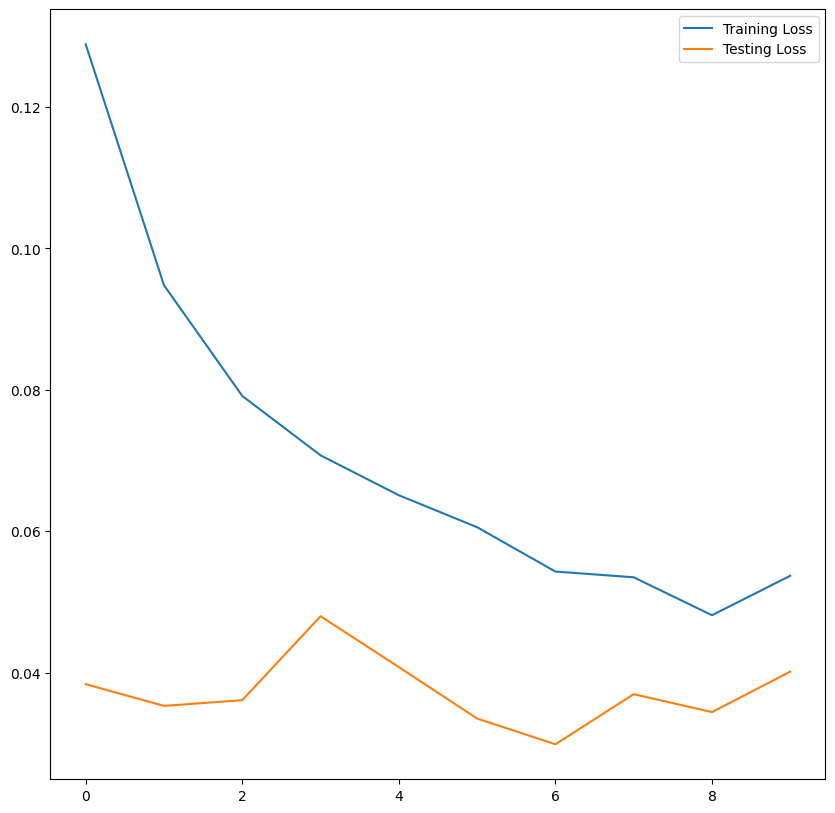

In [ ]:
# Plot the loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

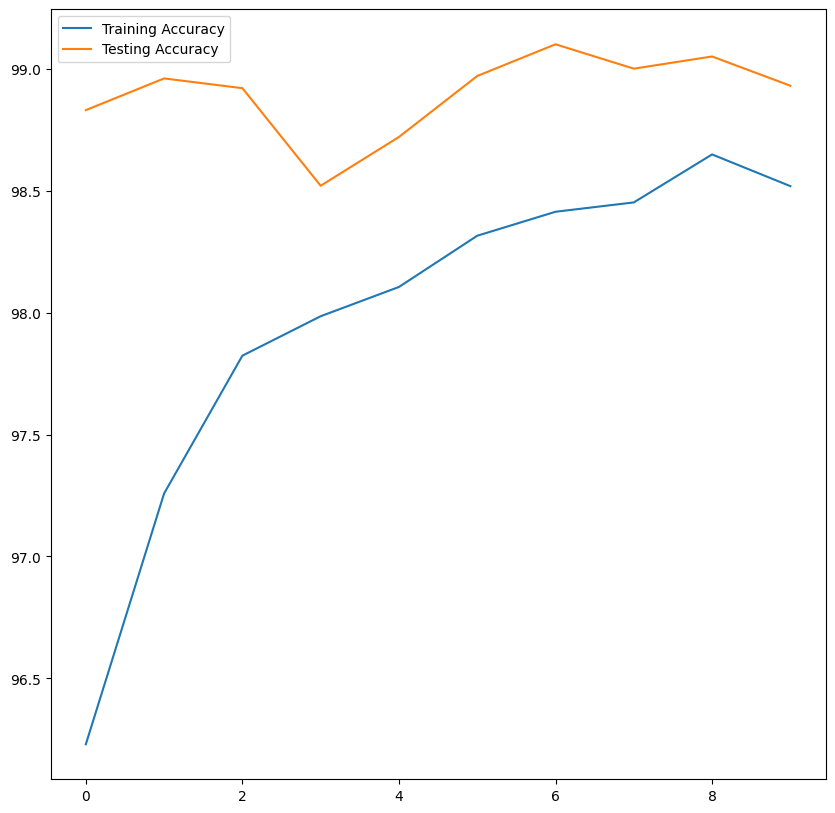

In [ ]:
# Plot the accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [ ]:
img = test_dataset[30][0].resize_((1, 1, 28, 28))
label = test_dataset[30][1]

model.eval()

if CUDA:
  model = model.cuda()
  img = img.cuda()

outputs = model(img)

_, predicted = torch.max(outputs, 1)
print("Predicted is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

RuntimeError: ignored

In [ ]:
#Predict your own image
def predict(img_name,model):
    image = cv2.imread(img_name,0)   #Read the image
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)   #Threshold the image
    img = 255-thresholded           #Apply image negative
    cv2.imshow('Original',img)      #Display the processed image
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = Image.fromarray(img)      #Convert the image to an array
    img = transforms_photo(img)     #Apply the transformations
    img = img.view(1,1,28,28)       #Add batch size
    img = Variable(img)             #Wrap the tensor to a variable

    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

In [ ]:
pred = predict('3.jpg', model)
print("The Predicted Label is {}".format(pred))